# Simpler Problem-One Dimension

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from plotly import tools
init_notebook_mode(connected = True)

## Defining Our Loss Function

In [3]:
x = np.array([-4, -3.4, -2.34, -.5, 0, 1.9, 3.04, 7.5, 8])
y = np.array([6.41, -.1, -10, 20.47, 20.04, -8, -8, -8, 2.32])

iplot(Figure(data = [Scatter(x= x, y=y)]))

In [4]:
class LossFunc:
    
    def __init__(self, order, x, y):
        self.order = order
        self.x_points = x
        self.y_points = y
        
    def build_func(self):
        fit = np.polyfit(self.x_points,self.y_points,self.order)
        self.f = np.poly1d(fit)
        return self.f

    def evaluate(self, t):
        return self.f(t)
    
    def print_loss_surface(self):
        grid = np.linspace(-5, 8, 1000)
        plt.plot(grid, self.evaluate(grid))
        plt.title('Loss Surface: f(x)')
        plt.show()

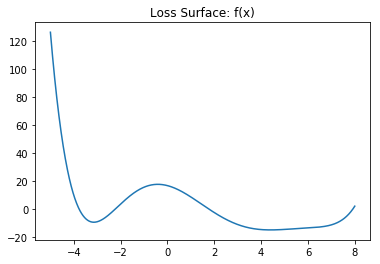

In [5]:
lf = LossFunc(6, x, y)
lf.build_func()
lf.print_loss_surface()

## Creating Local Entropy Surface & Minimizing

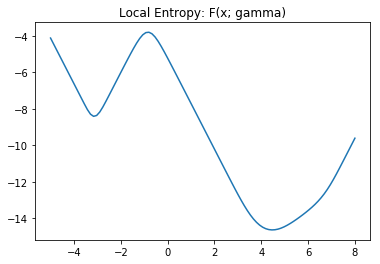

In [6]:
class SimpleProblem:
    
    def __init__(self, gamma, loss_func):
        self.gamma = gamma
        self.base_loss = loss_func
        
    def evaluate(self, t):
        def subfunc(x_prime):
            return np.exp(- self.base_loss(x_prime) - (1/2*self.gamma)*np.abs(t - x_prime))
        to_return = quad(subfunc, -np.inf, np.inf)[0]
        return -np.log(to_return)
    
    def print_local_entropy_surface(self, additional = []):
        add_array = np.array(additional)
        grid = np.linspace(-5, 8, 100)
        vals = [self.evaluate(j) for j in grid]
        plt.plot(grid, vals)
        if additional != []:
            add_vals = [self.evaluate(j) for j in add_array[:,0]]
            plt.scatter(add_array[:,0],
                        add_vals,
                        c = add_array[:,1],
                        cmap = 'viridis',
                        marker = 'o')
        plt.title('Local Entropy: F(x; gamma)')
        plt.show()
        
    def train_IS(self, sample_num, SG_steps):
        current = -4
        to_show = []
        for t in range(SG_steps):
            #print(current)
            if t % 1 == 0:
                to_append = [current, t]
                to_show.append(to_append)
            samples = np.random.normal(current,self.gamma,sample_num)
            weights = np.exp(-self.base_loss(samples))
            new_point = np.dot(weights, samples)/np.sum(weights)
            #if t< 10:
                #print(new_point)
            #current = current - self.gamma*(current - new_point)
            current = new_point
        print('Training Complete, Creating Chart')
        self.print_local_entropy_surface(to_show)
        return current
        
    def train_RW(self, iterate, burn, beta, SG_steps, joint):
        current = -4
        to_show = []
        burnt = False
        for j in range(SG_steps): 
            samples = []
            if j % 1 == 0:
                to_append = [current, j]
                to_show.append(to_append)
            for i in range(iterate):
                chain_pos = current
                if i > burn and burnt == False:
                    burnt = True
                prop = np.random.normal(chain_pos, beta, 1)[0]
                j_p = joint(prop)
                j_c = joint(chain_pos)
                alpha_num = j_p* norm.pdf(chain_pos,prop,1)
                alpha_denom = j_c*norm.pdf(prop,chain_pos,1)
                alpha = min(1, alpha_num/alpha_denom)
                if np.random.uniform(0,1,1) < alpha:
                    chain_pos = prop
                    if burnt:
                        samples.append(chain_pos)
                else:
                    if burnt:
                        samples.append(chain_pos)
            new_point = np.mean(samples)
            current = current - self.gamma*(current - new_point)
        print('Training Complete, Creating Chart')
        self.print_local_entropy_surface(to_show)
        return current
        
    def train_LD(self, SG_steps, LD_steps):
        current = -4
        to_show = []
        temps = np.array([1/x for x in range(1,LD_steps)])
        temp_sum = np.sum(temps)
        def df(f,x, h=0.1e-5):
            return ((f(x+h/2) - f(x-h/2))/h)
        for t in range(SG_steps):
            if t % 1 == 0:
                to_append = [current, t]
                to_show.append(to_append)
            expectation = 0
            for i,temp in enumerate(temps):
                chain_pos = current
                chain_pos = chain_pos - (temp/2)\
                * (df(self.base_loss, chain_pos)-self.gamma*(current-chain_pos))\
                + np.random.normal(0,temp,1)[0]
                expectation += chain_pos * temp
            new_point = expectation/temp_sum
            #if t< 10:
             #   print(new_point)
            #current = current - self.gamma*(current - new_point)
            current = new_point
        print('Training Complete, Creating Chart')
        self.print_local_entropy_surface(to_show)
        return current
    
    def train_quad(self, SG_steps):
        current = -4
        to_show = []
        for t in range(SG_steps):
            if (np.abs(current - 4.2) < .1):
                break
            if t % 1 == 0:
                to_append = [current, t]
                to_show.append(to_append)  
            def g(x):
                exppt1 = -self.base_loss(x)
                exppt2 = -((self.gamma/2)*(np.abs(current-x)**2))
                expon = exppt1 + exppt2
                return (x * np.exp(expon))
            if t == 0:
                plt.plot(np.linspace(-10,10,1000), g(np.linspace(-10,10,1000)))
                plt.show()
            expectation, err = quad(g, -5, 6)
            #print(expectation, err)
            current = current - self.gamma*(current - expectation)
        print('Training Complete, Creating Chart')
        self.print_local_entropy_surface(to_show)
        return current
    
sp = SimpleProblem(5, lf.evaluate)
sp.print_local_entropy_surface()

### Importance Sampling

Training Complete, Creating Chart


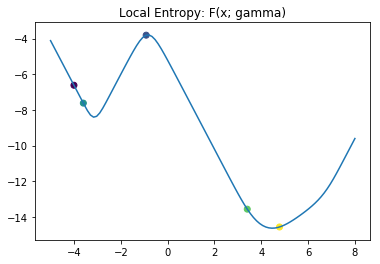

4.222098899670807

In [10]:
sp.train_IS(sample_num = 10, SG_steps = 5)

# Random Walk

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


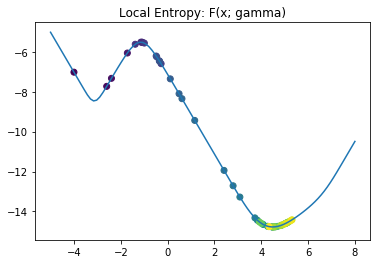

4.571281634351506

In [105]:
sp.train_RW(iterate = 100,
            burn = 50,
            beta = sp.gamma,
            SG_steps = 50,
            joint = sp.evaluate)

### Langevin Dynamics

Training Complete, Creating Chart


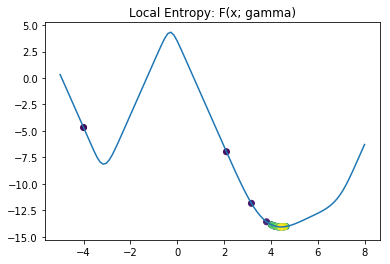

4.5244273728872075

In [237]:
sp.train_LD(SG_steps= 30, LD_steps = 1000)

### Quadrature

Training Complete, Creating Chart


/Users/ZacharyKaplan/Code/localentropy/alg/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



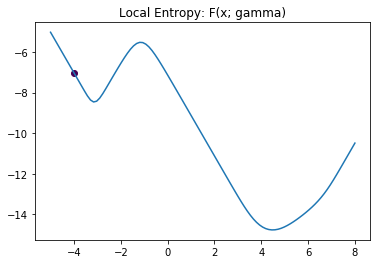

18268.900507471837

In [128]:
sp.train_quad(SG_steps = 20)